# T-ChroNet tutorial

**T-ChroNet** is a computational tool to create and analyse epigenetic networks of temporal biological data.

Befor starting the analysis, you have to install the conda environment for running the T-ChroNet script thorugh the following command: 
```
conda create -n TCHRONET os pandas numpy multiprocessing deepgraph sys igraph matplotlib seaborn leidenalg scipy
```

Then you can run the T-ChroNet script inside the TCHRONET environmet as follow:
```
conda activate TCHRONET
mkdir -p ./results
python ../TCHRONET.py -m /mnt/nas-safu01/analysis/scripts/ScriptSdigiove/RegNetATACProject/TRACES/vignette/data/thp1_test.tsv -o /mnt/nas-safu01/analysis/scripts/ScriptSdigiove/RegNetATACProject/TRACES/vignette/results/test_network.hdf -@ 2 -r 0.5
```

Then the edge list file will be contaiend into the results folder. The code below is used to find the communities of our network.

## Import libraryies and funcitons

In [33]:
import sys
import pandas as pd
import numpy as np
import igraph as ig
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir
from scipy.stats import zscore
import leidenalg as la


sys.path.append("../utils")
import tchronet_utils


np.random.seed(10)

%matplotlib inline

## Loading the Network

In [30]:
network_path = "./results/test_network.hdf"

e = pd.read_hdf( network_path)
e_df = e.reset_index()

G = ig.Graph.TupleList(e_df.itertuples(index=False), directed=False, weights=None, edge_attrs = 'corr')

## Finding best resolution Parameter

### Cluster Tree

/mnt/nas-safu01/analysis/scripts/ScriptSdigiove/RegNetATACProject/T-ChroNet/vignette/../utils/tchronet_utils.py:280: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


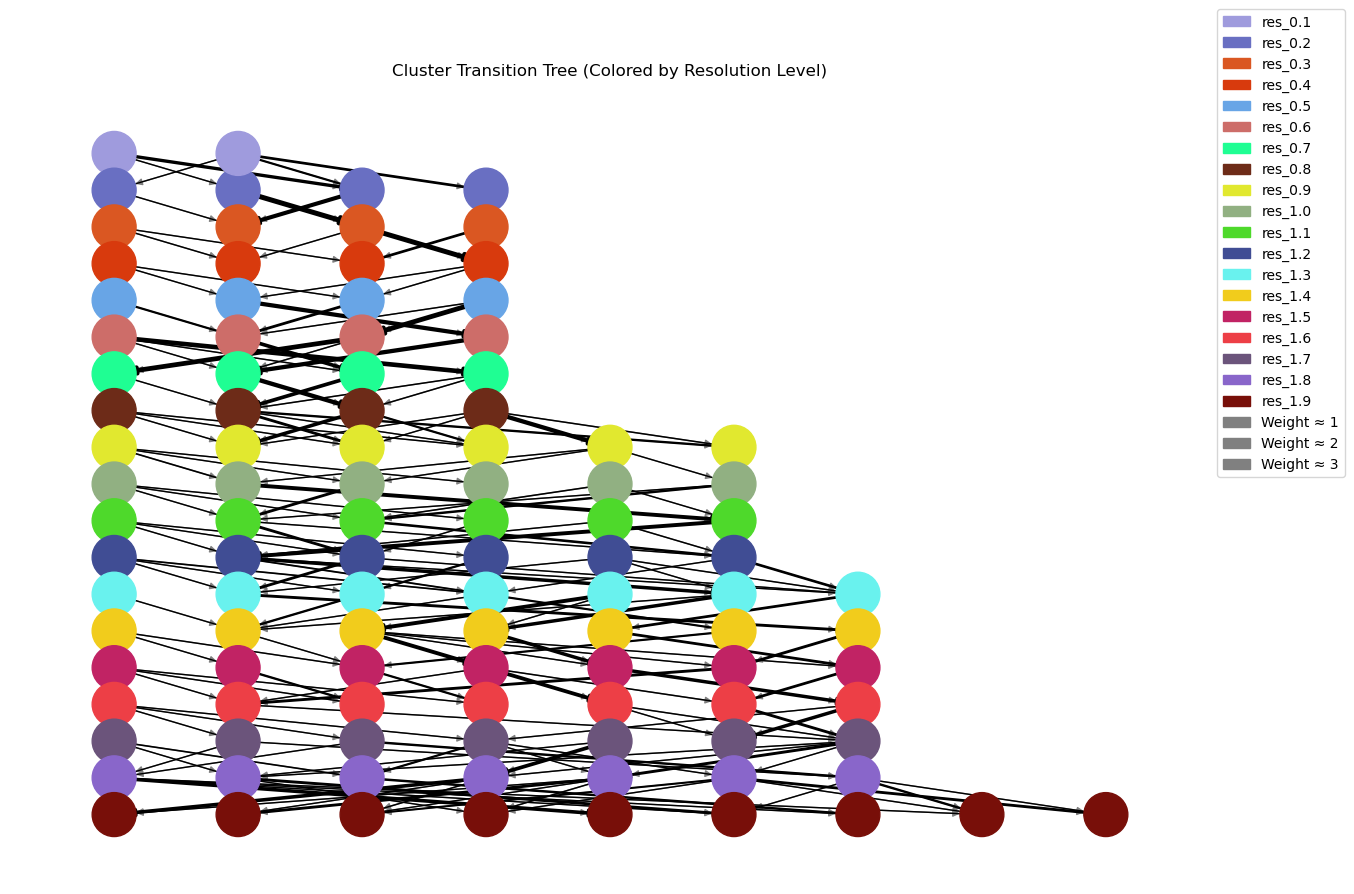

In [34]:
steps = [round(x, 2) for x in [0.1 * i for i in range(1, 21 + 1)]]

for x in steps :
    communities = la.find_partition( G , la.RBConfigurationVertexPartition  , resolution_parameter = x , weights = 'corr' , seed = 1234 ) #la.RBConfigurationVertexPartition la.CPMVertexPartition
    if x == 0.1 :
        data = {
            "Node": range(len(G.vs)),
            "Cluster_0.1": communities.membership
        }
        cluster_table = pd.DataFrame(data)

    else :
        cluster_table[ "Cluster_" + str(x)] = communities.membership

steps_plot = [round(x, 2) for x in [0.1 * i for i in range(1, 19)]]
tchronet_utils.plot_clusters_resolution(cluster_table , steps_plot)

### Modularity evaluation

In [ ]:
resolution_values = [round(x, 2) for x in [0.1 * i for i in range(1, 21 + 1)]]

modularity_scores = []
for x in list(resolution_values) :
    communities = la.find_partition( G , la.RBConfigurationVertexPartition  , resolution_parameter = x , weights = 'corr' , seed = 1234 )
    modularity = G.modularity(communities.membership)
    modularity_scores.append(modularity)

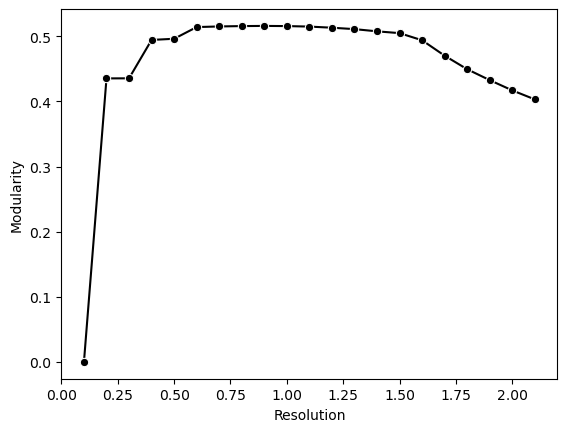

In [28]:
# Plot modularity and resolution
sns.lineplot(x=list(resolution_values) , y=modularity_scores ,  color = 'black' , marker= "o")
# Label the axes
plt.xlabel("Resolution")
plt.ylabel("Modularity")

plt.show()

## Finding Communities

One you have selected the best resolution parameter evaluating the communities stability and the modularity maximization. You can run leiden algorithm for community detection at the selected resolution

In [35]:
communities = la.find_partition( G , la.RBConfigurationVertexPartition  , resolution_parameter = 0.9 , weights = 'corr' , seed = 1234 ) # Change resolution_parameter for higher (e.g. 2) of lower resolution (e.g. 0.3 )

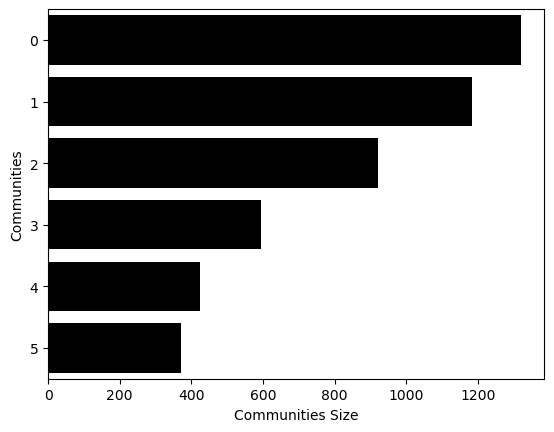

In [36]:
# Example data
values =[ len(x) for x in communities if len(x)>100]

# Plot
sns.barplot(x=values , y=list(range(len(values))) , orient = "h" , color = 'black' )

# Label the axes
plt.xlabel("Communities Size")
plt.ylabel("Communities")

# plt.savefig("/mnt/nas-safu/analysis/PhDsdigiove/method_coAcces/data/CellReport/pictures/communities_size.png", format="png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

## Plot trends

/home/sdigiove/miniconda3/envs/python311/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:gray'` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/sdigiove/miniconda3/envs/python311/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  func(*plot_args, **plot_kwargs)
/home/sdigiove/miniconda3/envs/python311/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:gray'` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/sdigiove/miniconda3/envs/python311/lib/python3.11/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `scale` parameter has been renamed and will be removed in 

<Figure size 2000x1200 with 0 Axes>

<Figure size 2000x1200 with 0 Axes>

<Figure size 2000x1200 with 0 Axes>

<Figure size 2000x1200 with 0 Axes>

<Figure size 2000x1200 with 0 Axes>

<Figure size 2000x1200 with 0 Axes>

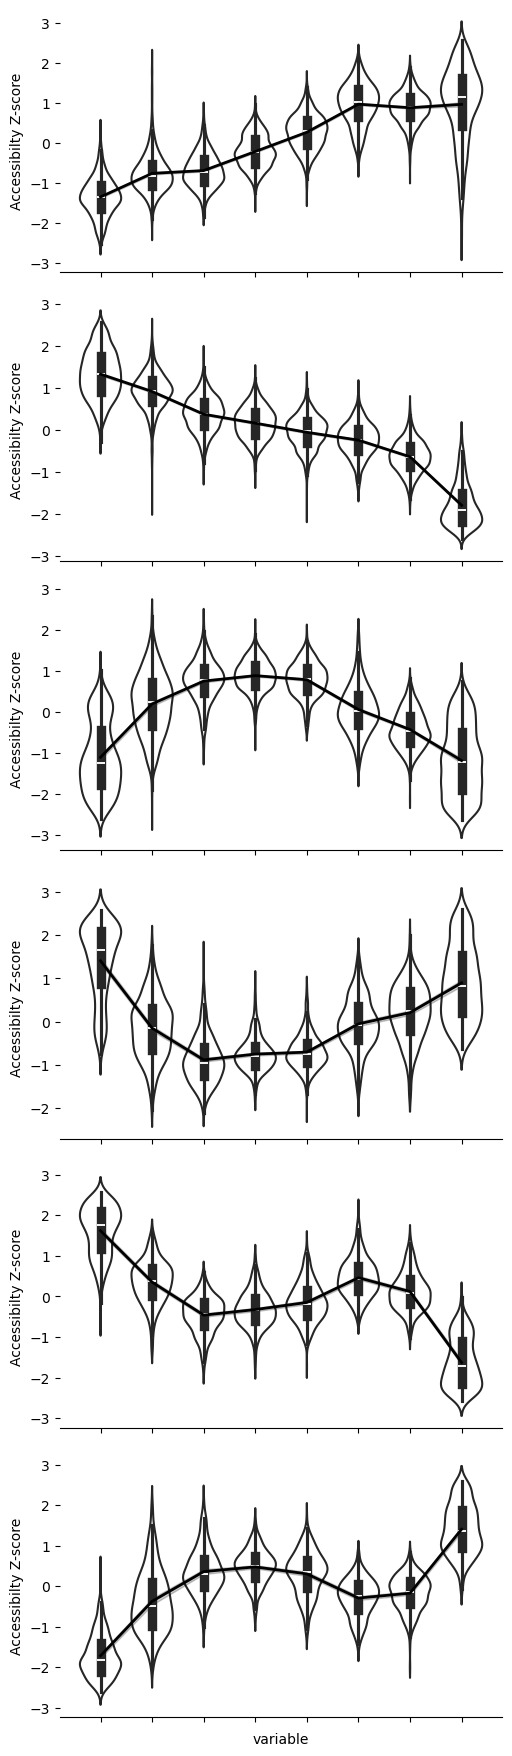

In [ ]:
communities_list = tchronet_utils.get_communities_names(G , communities)

counts_path = "./data/thp1_test.tsv"
data_matrix_df = pd.read_csv(counts_path , sep = "\t" , index_col = 0 )

tchronet_utils.plot_trends_zscore( communities_list , data_matrix_df , custom_ylim=(-2 , 2) )
# plt.savefig("") 

## Save communities bed file to folder

In [39]:
! mkdir -p ./results/bed/

In [42]:
# Save Community to files
for comm_number,commnity in enumerate(communities_list) :
    if len(commnity) > 100:
        save_path = f"./results/bed/community{comm_number}.bed"
        with open(save_path, 'w') as f:
            for line in commnity:
                line = line.split('-')
                line = '\t'.join(line)
                f.write(f"{line}\n")

## Homer Annotations

If you want to plot annotations, you need to install homer and run it on each community.
```
conda activate TCHRONET
conda install bioconda::homer

annotatePeaks.pl ./data/thp1_test.bed hg19 > ./results/thp1_test_anontations.txt

```

<Figure size 1000x1000 with 0 Axes>

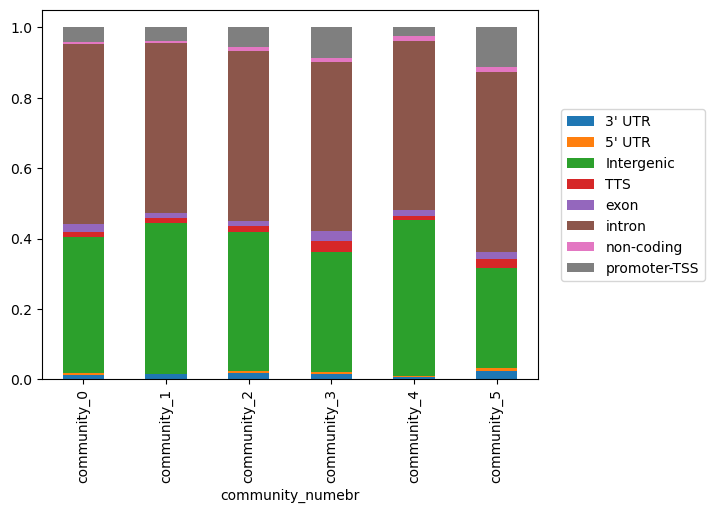

In [ ]:
homer_annotation_path = "./results/thp1_test_anontations.txt"

annotation = tchronet_utils.transform_annotation_homer(homer_annotation_path)
final_annotation = tchronet_utils.genomic_position_stackbar(communities_list, annotation)

plt.figure(figsize = (10 , 10 ))

final_annotation.groupby('community_numebr')['GenomicRegion'].value_counts(normalize=True).unstack('GenomicRegion').plot.bar(stacked=True ) 
plt.legend(loc = 'upper right' , bbox_to_anchor=(1.35, 0.75))

#plt.savefig('', bbox_inches='tight' , dpi=300)

The tutorial continues on the next Rmd for the pathways and Cistrom analyis...